# The Berry model

## Notation
* $d$ is the number of arms in the trial
* $\hat{I}$ is the sample information matrix.
* $\mathbf{y}$ is the *vector* probability-space data.
* $\mathbf{n}$ is the *vector* number of patients per arm.
* $\mathbf{\theta}$ is the *vector* logit-space true offsets
* $\mathbf{p_1}$ is the *vector* of targeted treatment effects.
* $\hat{\mathbf{\theta}}$ is the *vector* logit-space observed offsets.
* $\mu$ is the mean of the sharing distribution
* $\sigma$ is the standard deviation of the sharing distribution
* $\mu_0 = -1.34$ is the mean of the $\mu$ prior.
* $S = 10$ is the std dev of the $\mu$ prior.


## The basic model
\begin{align}
\mathbf{y}\mathbf{n} &\sim Binomial( \mathbf{\theta} + logit(\mathbf{p_1}), \mathbf{n})\\
\mathbf{\theta} &\sim N(\mu, \sigma^2)\\
\mu &\sim N(\mu_0, S^2)\\
\sigma^2 &\sim InvGamma(0.0005, 0.000005)\\

P(y, \theta, \sigma^2) &= P(\sigma^2) P(\theta|\sigma^2) P(y|\theta)
\end{align}



# Dirty Bayes

## Section 1: Approximating the posterior conditional on hyperparameters

### Step #1, exact, integrate out $\mu$, just use normal distribution conjugacy

\begin{align}
P(\mu) &= N(\mu_0, S^2)\\
P(\theta|\mu, \sigma^2) &= N(\mu_0, \sigma^2)\\
P(\theta|\sigma^2) &= P(\theta|\mu_0, \sigma^2, S^2) =  N(\mu_0, \sigma^2 I + S^2 J)
\end{align}

where J is the matrix of all 1s (everywhere, not just the diagonal?).

### Step #2, the important approximation!! Binomial asymptotically is Normal 

\begin{align}
\mathbf{y} \sim N(\mathbf{\theta} + \mathbf{p_1}, I^{-1})
\end{align}

### Step #3, introduce data to approximate likelihood:

\begin{align}
I^{-1} \approx \hat{I}^{-1} = \hat{p} (1 - \hat{p}) / n\\
P(y|\theta) = N(\mathbf{\theta} + \mathbf{p_1}, I^{-1}) \approx N(\hat{\mathbf{\theta}} + \mathbf{p_1}, \hat{I}^{-1})\\
\end{align}

### Step #4, combine the two Gaussians $P(y|\theta)$ and $P(\theta|\sigma^2)$:

\begin{align}
P(\theta|y,\sigma^2) = \frac{P(\theta|\sigma^2)P(y|\theta)}{P(y|\sigma^2)}
\end{align}

Using Gaussian posterior conjugacy: 
\begin{align}
\theta|y, \sigma^2 \sim N(\mu_d, \Sigma_d)\\
\mu_d = ...\\
\Sigma_d = ...\\
\end{align}


## Section 2: Integration over hyperparameters
### Step #5: integrate out $\sigma^2$

\begin{align}
P(\theta|y) = \int P(\theta| y, \sigma^2)P(\sigma^2|y) d\sigma^2
\end{align}

### Step #6: manipulate $\sigma^2$ posterior

By definition of conditional prob:
\begin{align}
P(\sigma^2|y) = \frac{P(\sigma^2, y)}{P(y)}
\end{align}

### Step #7: computing the joint distribution $P(\sigma^2, y)$

\begin{align}
P(\sigma^2, y) &= P(\sigma^2)P(y|\sigma^2)\\
y|\sigma^2 &\sim N(\mu, \hat{I}^{-1} + \Sigma_{\sigma^2})
\end{align}
Also, recall the prior:
\begin{align}
\sigma^2 &\sim InvGamma(0.0005, 0.000005)\\
\end{align}

### Step #8: compute $P(y)$ posterior

Once we have computed the joint probability $P(\sigma^2, y)$, the denominator/marginal/data-prior $P(y)$ can be easily computed by numerically integrating over $\sigma^2$.

### Step #9: actually do the integral from step #5.

TODO: this should be updated to correct for the fact that we compute relevant quantities like exceedance probabilities before integrating.
Because this integral is done numerically, we now have a mixture of Gaussians. The mean and variance of a weighted mixture of gaussians is a well-known formula: INSERT FORMULA HERE.


In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

import scipy.stats
import numpy as np
import inla
import berry
import dirty_bayes

In [2]:
b = berry.Berry(sigma2_n=90, sigma2_bounds=(1e-8, 1e3)) 

# I got this data by deconstructing the graphs in in Figure 1 of Berry et al 2013.
n_i = np.array([[i] * 4 for i in [10, 15, 20, 25, 30, 35]])
y_i = np.array(
    [
        [1, 6, 3, 3],
        [3, 8, 5, 4],
        [6, 9, 7, 5],
        [7, 10, 8, 7],
        [8, 10, 9, 8],
        [11, 11, 10, 9],
    ]
)
data = np.stack((y_i, n_i), axis=2)

In [3]:
data.shape

(6, 4, 2)

In [4]:
post_hyper, report = inla.calc_posterior_hyper(b, data)
inla_stats = inla.calc_posterior_x(post_hyper, report, b.suc_thresh)
db_stats = dirty_bayes.calc_dirty_bayes(y_i, n_i, b.mu_0, b.logit_p1, b.suc_thresh, b.sigma2_rule)

(6, 90, 4, 4)


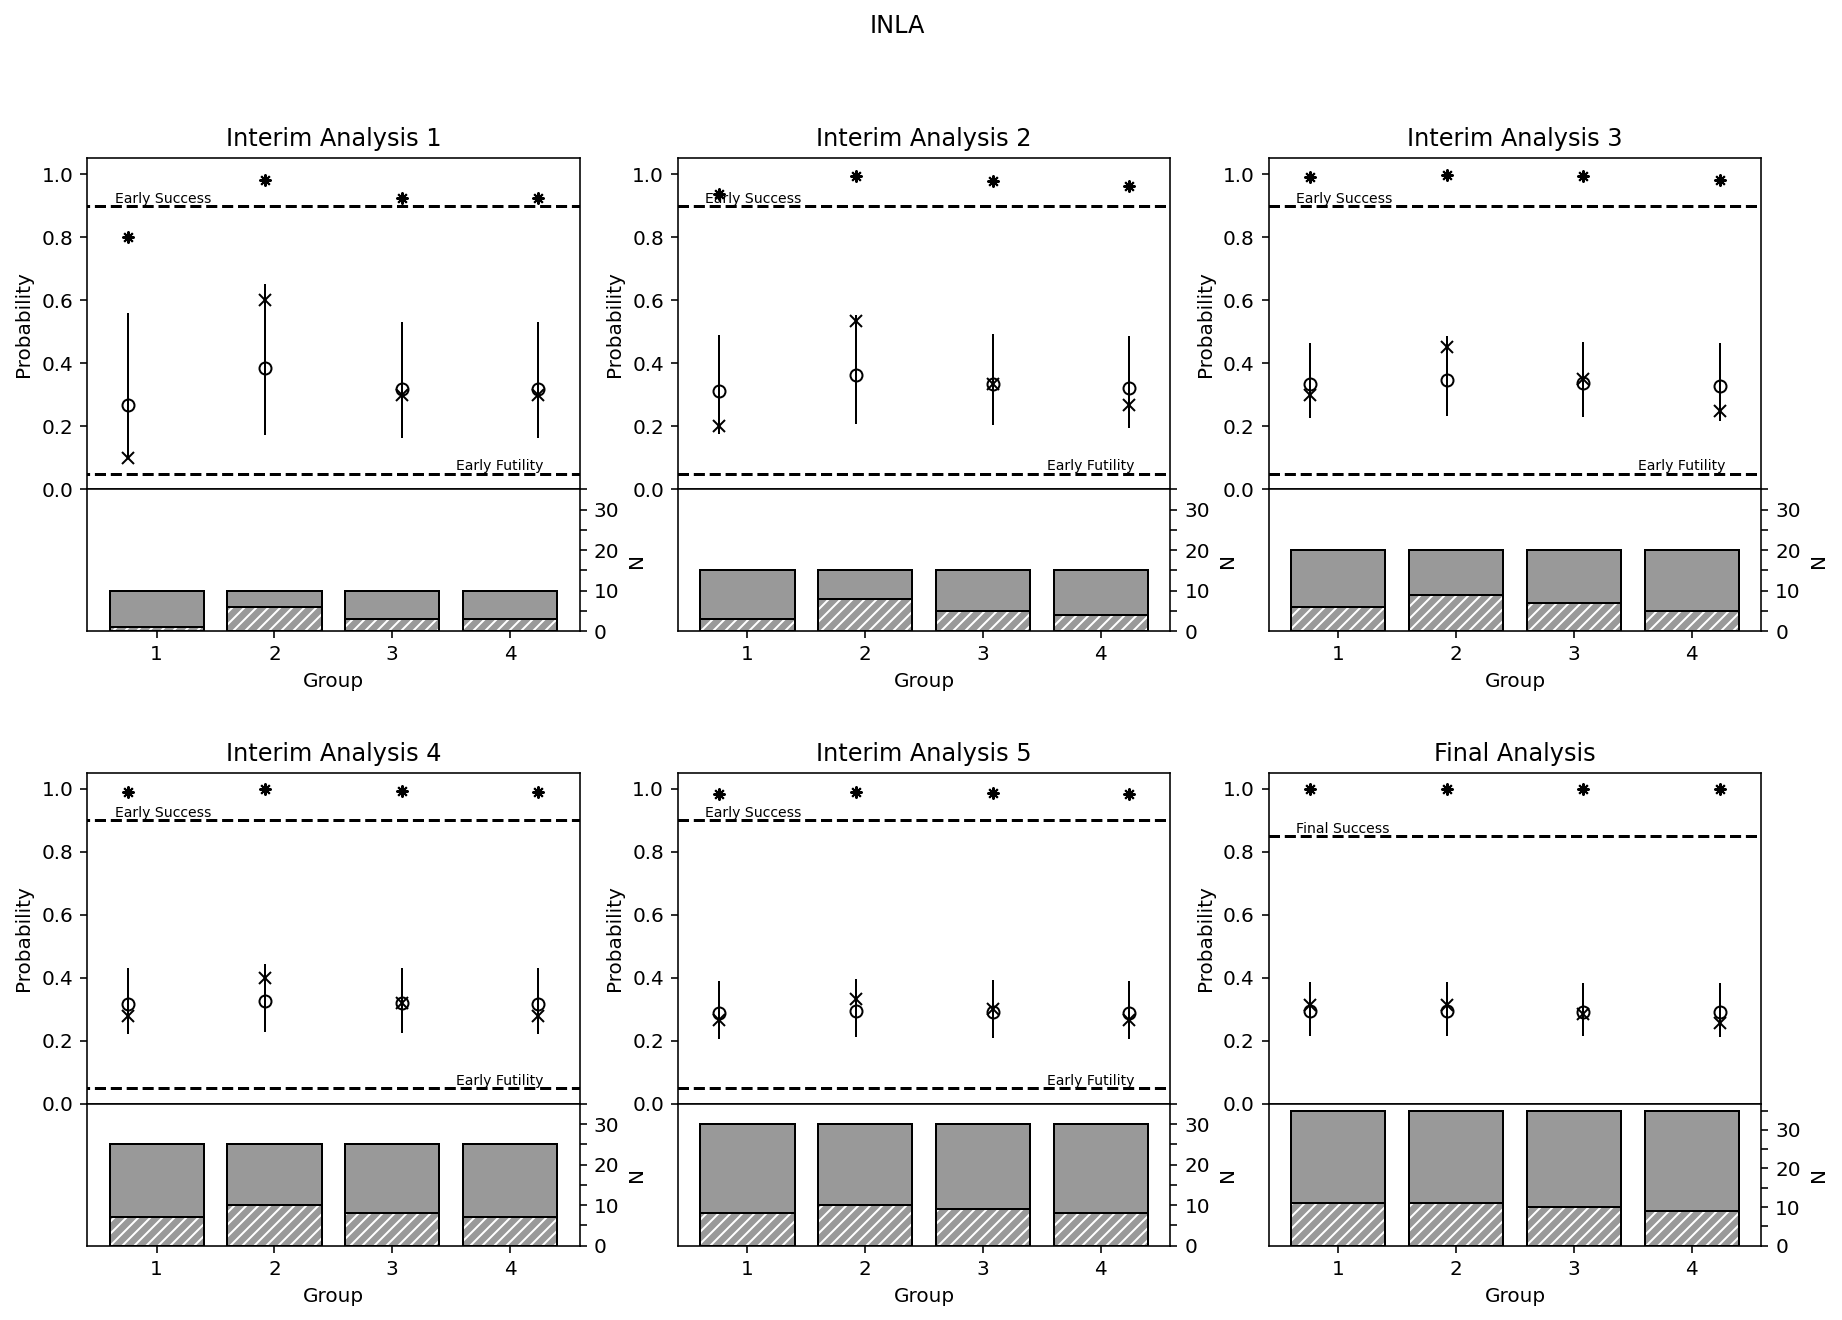

KeyError: 'mu_map'

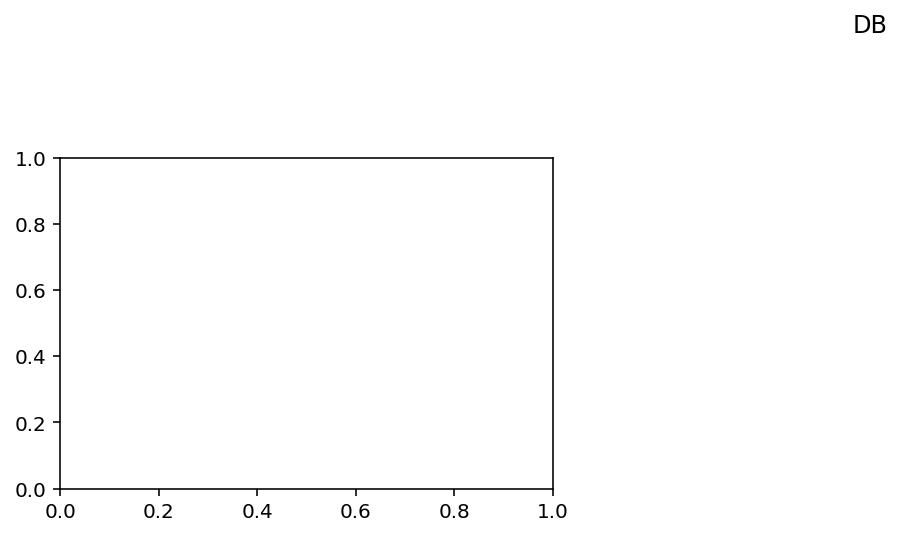

In [5]:
berry.figure1_plot(b, "INLA", data, inla_stats)
berry.figure1_plot(b, "DB", data, db_stats)

# Figure 2

In [138]:
# I got this data by deconstructing the graphs in in Figure 1 of Berry et al 2013.
n_i = np.array(
    [
        [10, 10, 10, 10],
        [15, 15, 15, 15],
        [20, 20, 20, 20],
        [20, 20, 25, 25],
        [20, 20, 30, 30],
        [20, 20, 35, 35],
    ]
)
y_i = np.array(
    [
        [0, 1, 3, 3],
        [0, 1, 4, 5],
        [0, 1, 6, 6],
        [0, 1, 6, 7],
        [0, 1, 7, 8],
        [0, 1, 9, 10],
    ],
    dtype=np.float64,
)
data = np.stack((y_i, n_i), axis=2)

y_i_no0 = y_i.copy()
y_i_no0[y_i_no0 == 0] = 0.5
data_no0 = np.stack((y_i_no0, n_i), axis=2)

post_hyper, report = inla.calc_posterior_hyper(b, data_no0)
inla_stats = inla.calc_posterior_x(post_hyper, report, b.suc_thresh)
db_stats = dirty_bayes.calc_dirty_bayes(y_i_no0, n_i, b.mu_0, b.logit_p1, b.suc_thresh, b.sigma2_rule)

(6, 90, 4, 4)


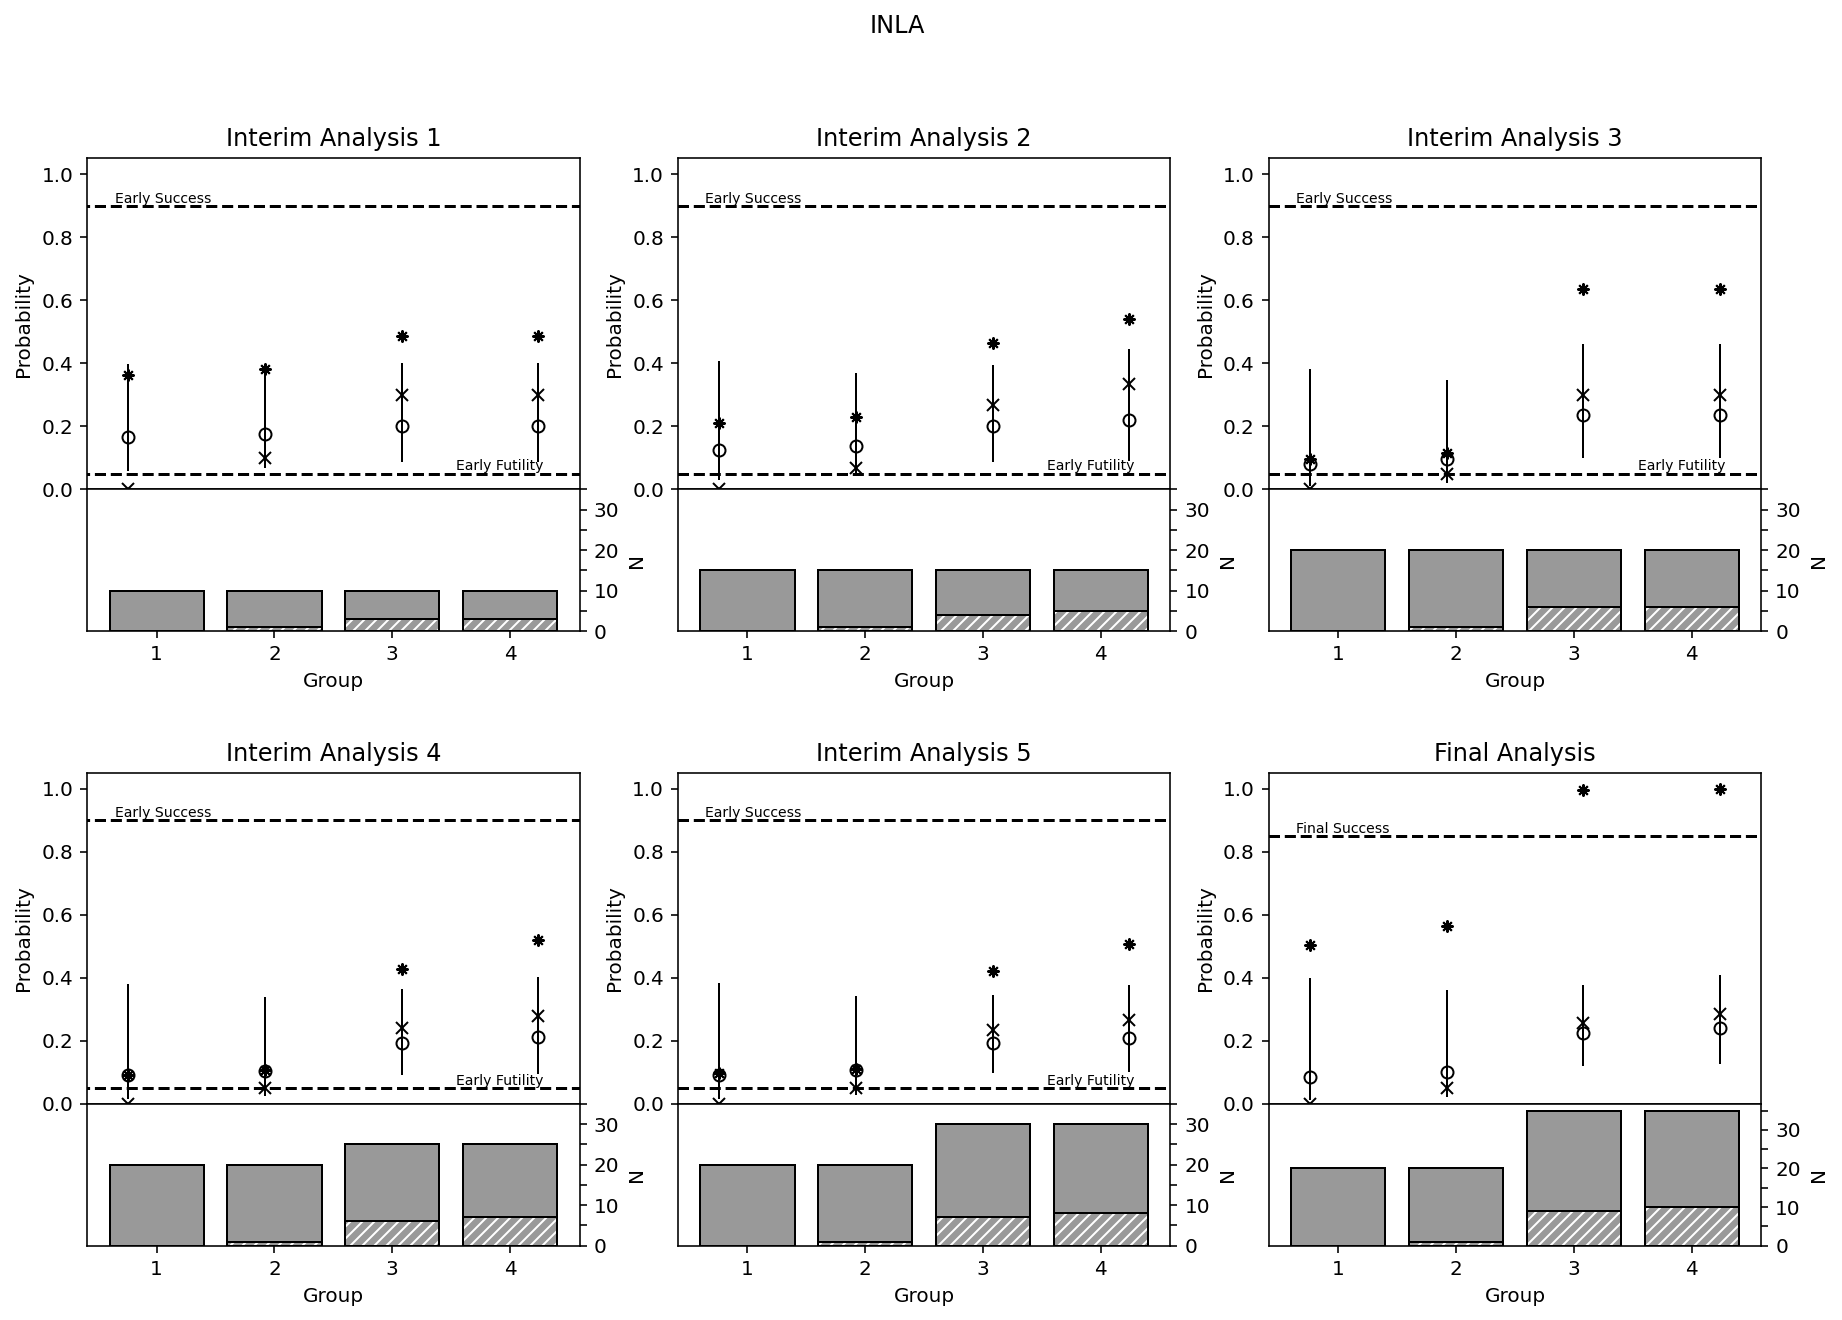

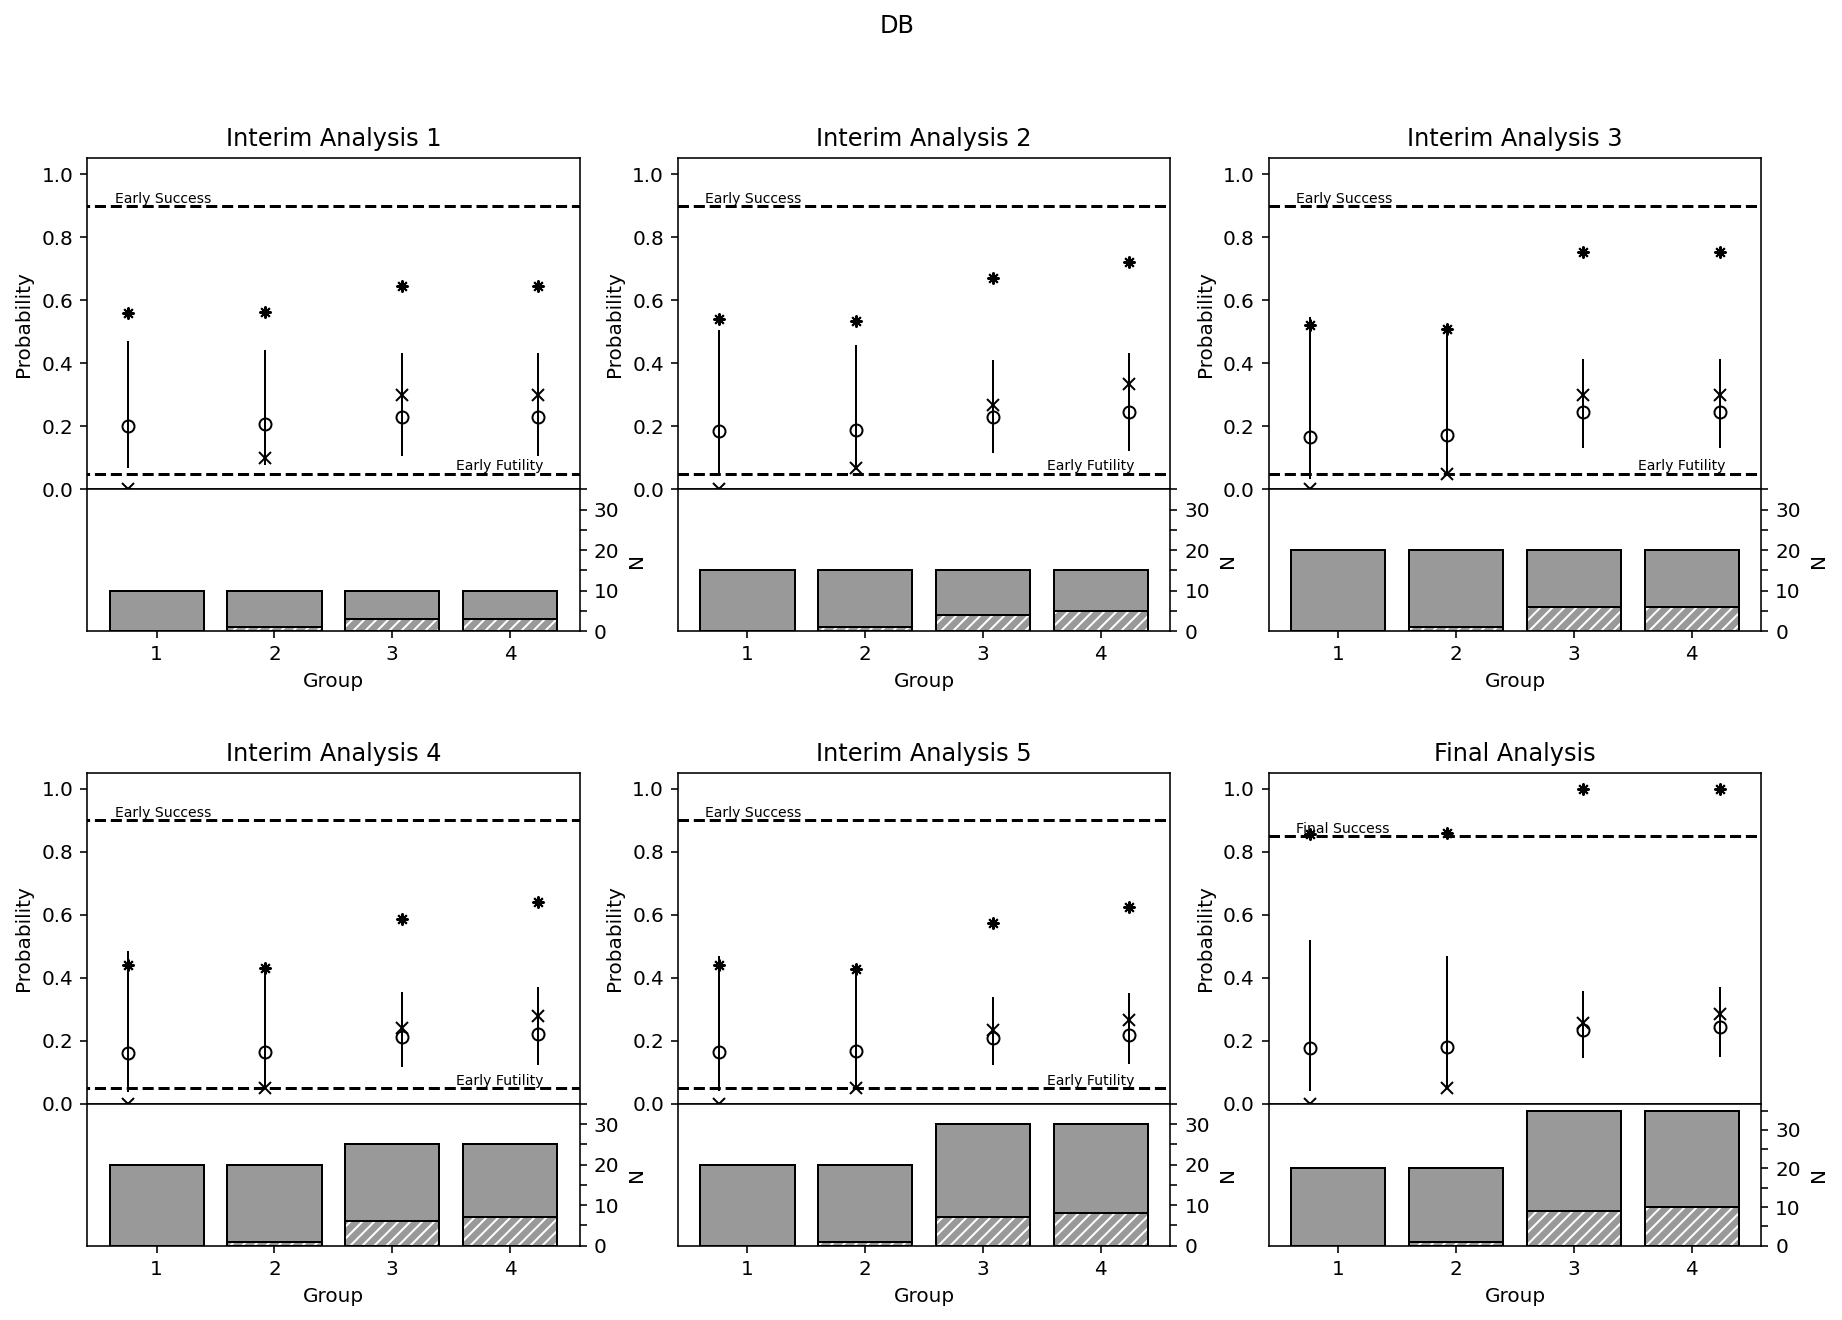

In [115]:
berry.figure1_plot(b, "INLA", data, inla_stats)
berry.figure1_plot(b, "DB", data, db_stats)

In [116]:
import exact
import util

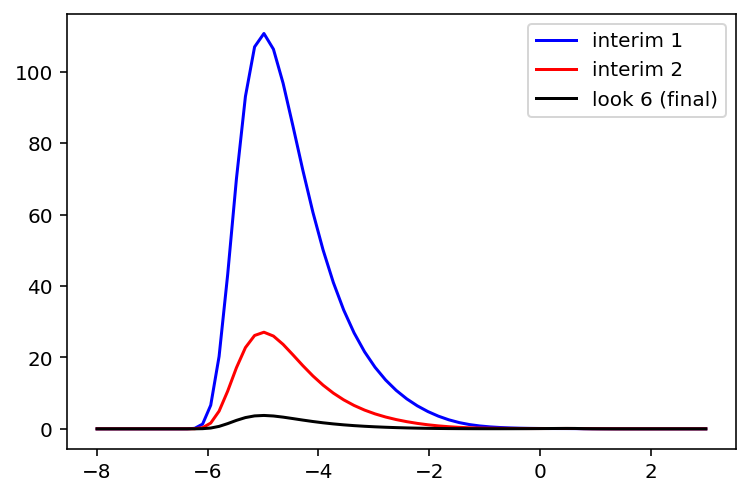

In [128]:
p_sigma_g_y = exact.integrate(b, data[[0,1,5]], integrate_thetas=(0, 1, 2, 3))
p_sigma_g_y /= np.sum(p_sigma_g_y * b.sigma2_rule.wts, axis=1)[:, None]
# TODO: would be cool to do a CDF here using a generated product rule for each subset of points.
plt.plot(np.log10(b.sigma2_rule.pts), p_sigma_g_y[0], 'b', label='interim 1')
plt.plot(np.log10(b.sigma2_rule.pts), p_sigma_g_y[1], 'r', label='interim 2')
plt.plot(np.log10(b.sigma2_rule.pts), p_sigma_g_y[2], 'k', label='look 6 (final)')
plt.legend()
plt.show()

In [174]:

t0_rule = util.simpson_rule(101, -7, 1.5)
p_t0_g_y = exact.integrate(
    b, data[[0,1,5]],
    integrate_sigma2=True,
    integrate_thetas=(1, 2, 3),
    fixed_dims={0:t0_rule},
)

p_t0_g_y /= np.sum(p_t0_g_y * t0_rule.wts, axis=1)[:, None]

KeyboardInterrupt: 

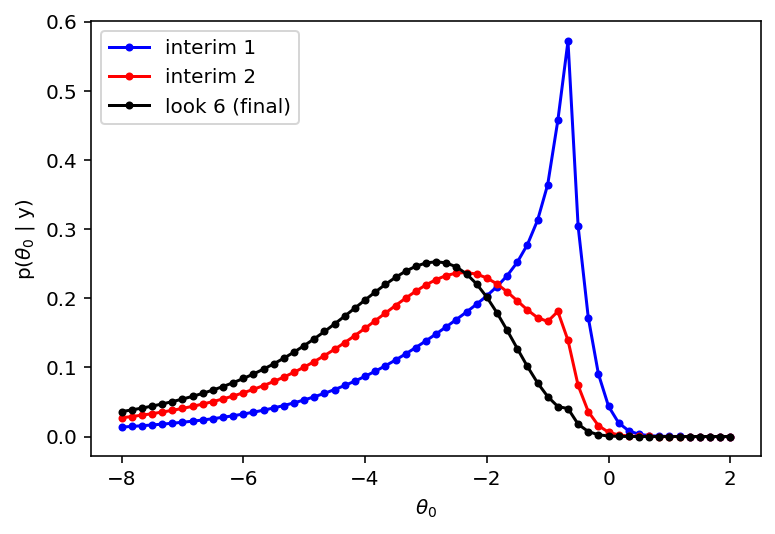

In [ ]:

plt.plot(t0_rule.pts, p_t0_g_y[0], 'b-o', markersize=3, label='interim 1')
plt.plot(t0_rule.pts, p_t0_g_y[1], 'r-o', markersize=3, label='interim 2')
plt.plot(t0_rule.pts, p_t0_g_y[2], 'k-o', markersize=3, label='look 6 (final)')
plt.legend()
plt.ylabel(r'p($\theta_0$ | y)')
plt.xlabel(r'$\theta_0$')
plt.show()

In [ ]:
theta_map = t0_rule.pts[np.argmax(p_t0_g_y, axis=1)]
theta_map

array([-0.66666667, -2.33333333, -2.83333333])

In [175]:
t0_rule.pts[:3], t0_rule.wts[:3]

(array([-7.   , -6.915, -6.83 ]), array([0.02833333, 0.11333333, 0.05666667]))

In [176]:
cdf = []
cdf_pts = []
for i in range(3, t0_rule.pts.shape[0], 2):
    # Note that t0_rule.wts[:i] will be different from cdf_rule.wts!!
    cdf_rule = util.simpson_rule(i, t0_rule.pts[0], t0_rule.pts[i-1])
    cdf.append(np.sum(p_t0_g_y[:,:i] * cdf_rule.wts[:i], axis=1))
    cdf_pts.append(t0_rule.pts[i-1])
cdf = np.array(cdf)
cdf_pts = np.array(cdf_pts)

ValueError: operands could not be broadcast together with shapes (3,61) (63,) 

In [ ]:
cilow = cdf_pts[np.argmax(cdf > 0.025, axis=0)]
cihi = cdf_pts[np.argmax(cdf > 0.975, axis=0)]
cilow, cihi

(array([-6.33333333, -7.        , -7.33333333]),
 array([ 0.        , -0.33333333, -1.        ]))

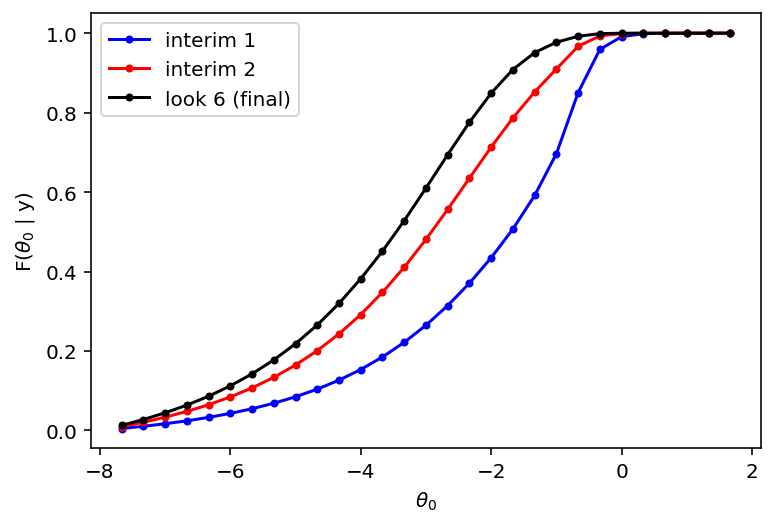

In [ ]:
plt.plot(cdf_pts, cdf[:, 0], 'b-o', markersize=3, label='interim 1')
plt.plot(cdf_pts, cdf[:, 1], 'r-o', markersize=3, label='interim 2')
plt.plot(cdf_pts, cdf[:, 2], 'k-o', markersize=3, label='look 6 (final)')
plt.legend()
plt.ylabel(r'F($\theta_0$ | y)')
plt.xlabel(r'$\theta_0$')
plt.show()

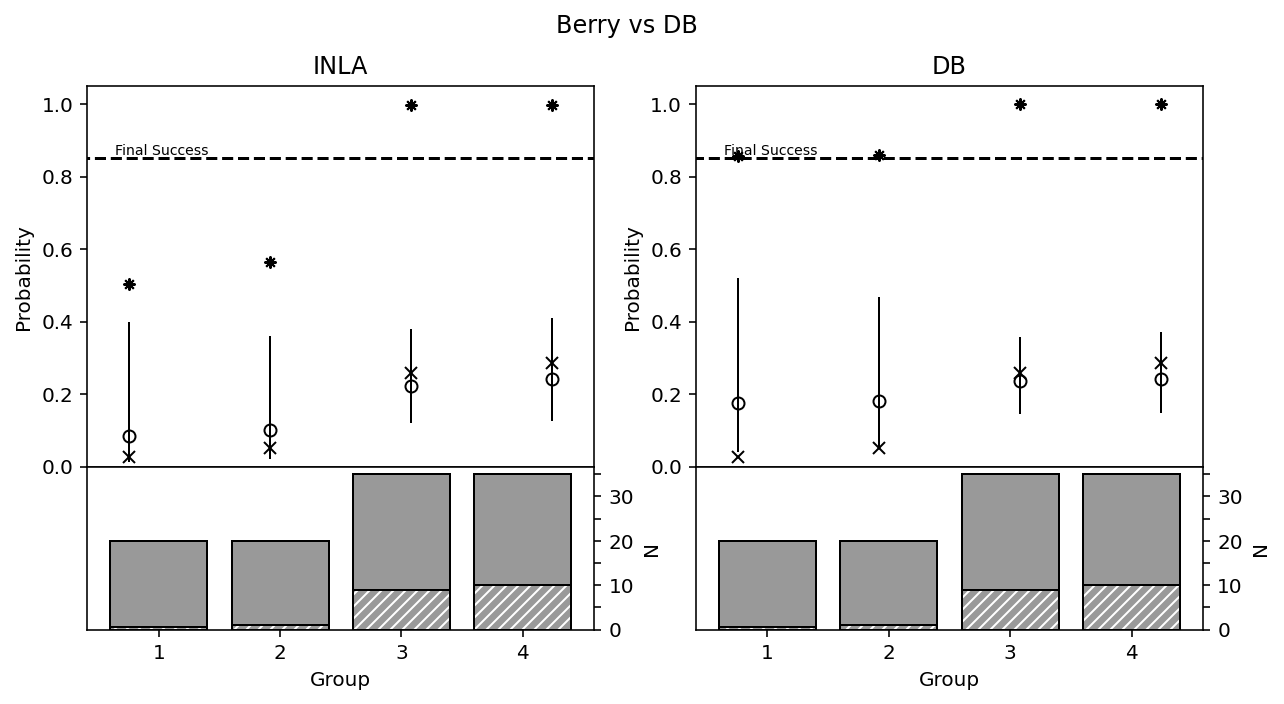

In [32]:

fig = plt.figure(figsize=(10, 5))
plt.suptitle('Final analysis')
outergs = fig.add_gridspec(1, 2, hspace=0.3)
innergs = outergs[0].subgridspec(
    2, 1, wspace=0, hspace=0, height_ratios=[0.7, 0.3]
)
berry.figure1_subplot(innergs[0], innergs[1], 5, b, data, inla_stats, title='INLA')
innergs = outergs[1].subgridspec(
    2, 1, wspace=0, hspace=0, height_ratios=[0.7, 0.3]
)
berry.figure1_subplot(innergs[0], innergs[1], 5, b, data, db_stats, title='DB')

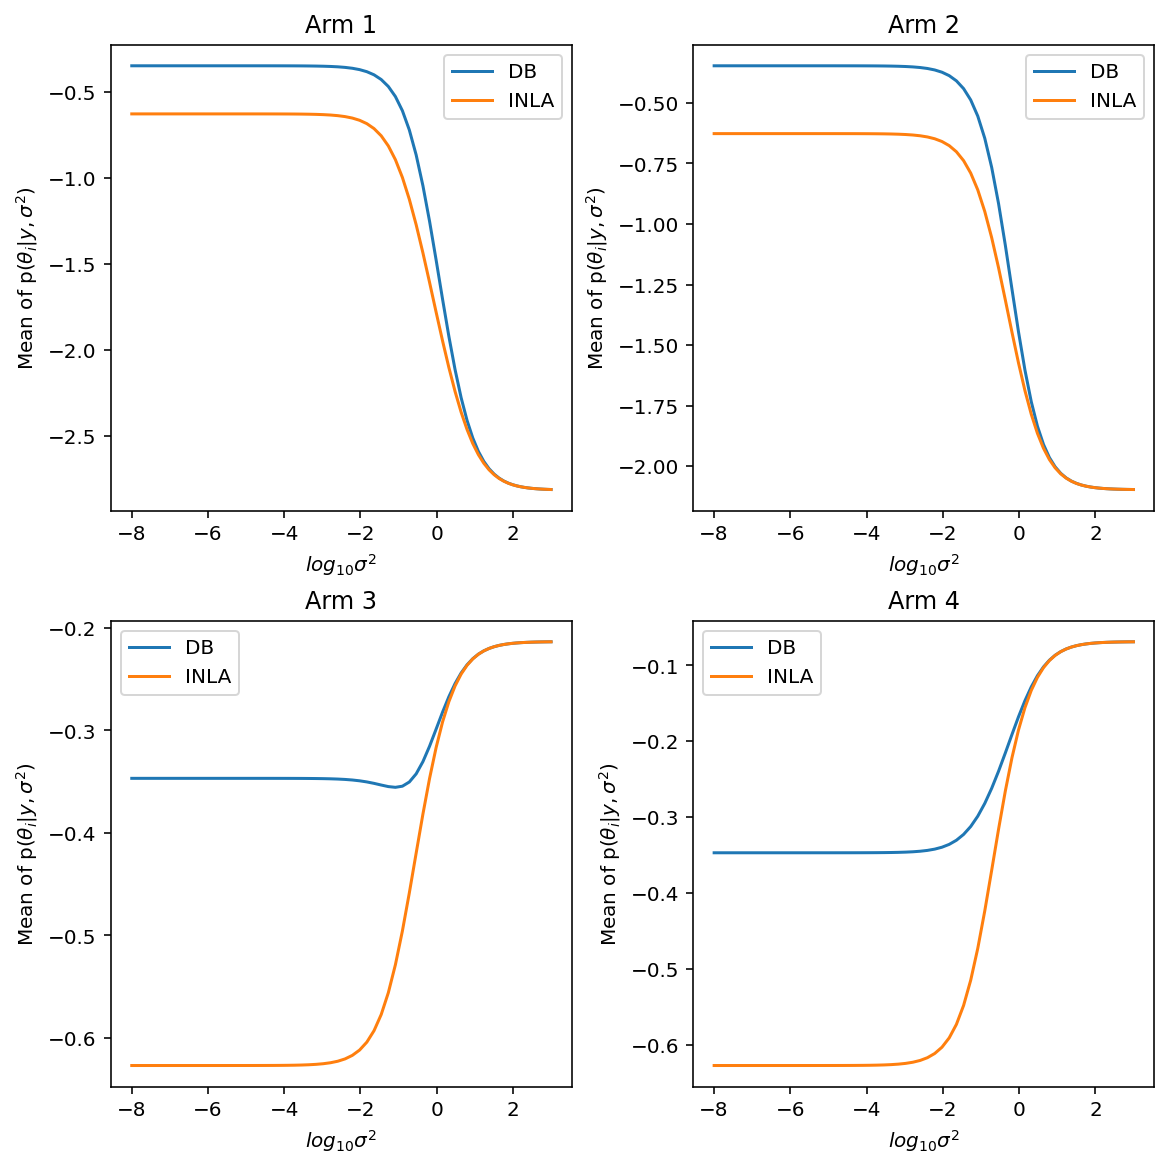

In [38]:
plt.figure(figsize=(8, 8), constrained_layout=True)
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title(f"Arm {i+1}")
    inla_graph = report['x0'][5, :, i]
    db_graph = db_stats["mu_posterior"][5, :, i]
    plt.plot(np.log10(b.sigma2_rule.pts), db_graph, label="DB")
    plt.plot(np.log10(b.sigma2_rule.pts), inla_graph, label="INLA")
    plt.ylabel(r"Mean of p($\theta_{i} | y, \sigma^2$)")
    plt.xlabel("$log_{10} \sigma^2$")
    plt.legend()
plt.show()

### Skewness in the marginals

Why is the confidence interval on the 0-th arm in the figure above so large? This is a case where one of the core INLA assumptions breaks down. INLA assumes that p(x|y,\theta) is approximately normal. In this particular case, that assumption is not correct. Intuitively, with 0 successes out of 20 patients, there is a lot more potential for small $x_0$ values than potential for large $x_0$ values. As you can see below, there is substantial skewness. There are approaches to deal with this. See here: https://github.com/mikesklar/kevlar/issues/15

In [ ]:
x0_vs = np.linspace(-15, 5, 100)
x123_vs = np.full_like(x0_vs, -1.0)
x = np.array([x0_vs, x123_vs, x123_vs, x123_vs]).T.copy()
lj = model.log_joint(model, x, data[0], np.array([[-1.0, 10.0]]))
plt.plot(x0_vs, np.exp(lj))
plt.show()

In [ ]:
mu_post, sigma_post = inla.calc_posterior_x(post_theta2, report2)

# expit(mu_post) is the posterior estimate of the mean probability.
p_post = scipy.special.expit(mu_post)

# two sigma confidence intervals transformed from logit to probability space.
cilow = scipy.special.expit(mu_post - 2 * sigma_post)
cihigh = scipy.special.expit(mu_post + 2 * sigma_post)

In [ ]:
cilow[0], cihigh[0]

In [ ]:
total_sum = np.sum(np.exp(lj))
mean = x0_vs[np.argmax(np.exp(lj))]
ci025 = x0_vs[np.argmax(np.cumsum(np.exp(lj)) / total_sum > 0.05)]
ci975 = x0_vs[np.argmax(np.cumsum(np.exp(lj)) / total_sum > 0.95)]
ci025, ci975, np.abs(mean - ci025), np.abs(mean - ci975), scipy.special.expit(
    ci025
), scipy.special.expit(ci975)

# Simulation

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

import scipy.stats
import numpy as np
import inla

In [ ]:
def log_gauss_rule(N, a, b):
    A = np.log(a)
    B = np.log(b)
    p, w = inla.gauss_rule(N, a=A, b=B)
    pexp = np.exp(p)
    wexp = np.exp(p) * w
    return (pexp, wexp)


a = 1e-8
b = 1e3
pexp, wexp = log_gauss_rule(90, a, b)
alpha = 0.0005
beta = 0.000005
f = scipy.stats.invgamma.pdf(pexp, alpha, scale=beta)
exact = scipy.stats.invgamma.cdf(b, alpha, scale=beta) - scipy.stats.invgamma.cdf(
    a, alpha, scale=beta
)
est = np.sum(f * wexp)
plt.plot(np.log(pexp) / np.log(10), f)
plt.xlabel("$log_{10}\sigma^2$")
plt.ylabel("$PDF$")
plt.show()
print("exact CDF: ", exact),
print("numerical integration CDF: ", est)
print("error: ", est - exact)
sigma2_rule = (pexp, wexp)

In [ ]:
p0 = np.array(
    [0.05, 0.05, 0.1, 0.2]
)  # rate of response below this is the null hypothesis
p1 = np.array(
    [0.2, 0.2, 0.3, 0.4]
)  # rate of response above this is the alternative hypothesis.
# p0 = np.array([0.1, 0.1, 0.1, 0.1]) # rate of response below this is the null hypothesis
# p1 = np.array([0.3, 0.3, 0.3, 0.3]) # rate of response above this is the alternative hypothesis.
# rate of response > p0 and < p1 is gray area.
p0_x = scipy.special.logit(p0)

pmid = (p0 + p1) / 2
pmid_x = scipy.special.logit(pmid)

# final evaluation criterion
# accept the alternative hypo if Pr(p[i] > p0|data) > pfinal_thresh[i]
pfinal_thresh = np.array([0.82, 0.82, 0.85, 0.9])

# early stopping criteria
pmid_accept = 0.9
pmid_fail = 0.05

prior_mu_mean = scipy.special.logit(0.1)


def berry_prior(theta):
    mu = theta[..., 0]
    mu_prior = scipy.stats.norm.logpdf(mu, prior_mu_mean, 100)

    sigma2 = theta[..., 1]
    alpha = 0.0005
    beta = 0.000005
    sigma2_prior = scipy.stats.invgamma.logpdf(sigma2, alpha, scale=beta)
    return mu_prior + sigma2_prior


model = inla.binomial_hierarchical()
model.log_prior = berry_prior

In [ ]:
%load_ext line_profiler

In [ ]:
np.random.seed(1000)


def sim(n_sims, N, p):
    return np.stack(
        (scipy.stats.binom.rvs(N, p, size=(n_sims, 4)), np.full((n_sims, 4), N)), axis=2
    )


n_sims = 200

scenarios = {
    "Null": [0.05, 0.05, 0.1, 0.2],
    "Alternative": [0.2, 0.2, 0.3, 0.4],
    "One in the Middle": [0.2, 0.2, 0.2, 0.5],
    "All in the Middle": [0.15, 0.15, 0.2, 0.3],
    "One Nugget": [0.05, 0.05, 0.1, 0.4],
    "2 Null, 2 Alternative": [0.05, 0.05, 0.3, 0.4],
}

# Number of patients at the first look.
N_0 = 10

# Number of patients added per look.
deltaN = 5

In [ ]:
results = dict()
n_looks = 6
for k in scenarios:
    results[k] = dict(
        data=[], mu_post=[], sigma_post=[], p_success=[], success_by_look=[]
    )
    p = scenarios[k]
    data = sim(n_sims, N_0, p)

    results[k]["data"] = []
    success = np.zeros((n_sims, 4), dtype=bool)
    stopping_time = np.full((n_sims, 4), -1, dtype=np.int32)
    for look in range(n_looks):
        results[k]["data"].append(data.copy())

        mu_rule = inla.gauss_rule(21, -5, 5)
        sigma2_rule = log_gauss_rule(21, 1e-7, 1e3)
        post_theta, report = inla.calc_posterior_theta(
            model, data, (mu_rule, sigma2_rule)
        )
        mu_post, sigma_post = inla.calc_posterior_x(post_theta, report)
        results[k]["mu_post"].append(mu_post)
        results[k]["sigma_post"].append(sigma_post)

        if look < 5:
            p_success = 1.0 - scipy.stats.norm.cdf(pmid_x, mu_post, sigma_post)
            stop_success = 0 * (
                p_success > pmid_accept
            )  # no early stopping for success
            stop_fail = p_success < pmid_fail
        else:
            p_success = 1.0 - scipy.stats.norm.cdf(p0_x, mu_post, sigma_post)
            stop_success = p_success > pfinal_thresh[None, :]
            stop_fail = p_success <= pfinal_thresh[None, :]
        success[stop_success] = True
        stop = stop_success | stop_fail
        update_stopping = (stop & (stopping_time == -1)).astype(bool)
        stopping_time[update_stopping] = look

        results[k]["p_success"].append(p_success)
        results[k]["success_by_look"].append(stop_success)

        new_data = sim(n_sims, deltaN, p)
        data += new_data
    results[k]["success_by_look"] = np.array(results[k]["success_by_look"])
    results[k]["stopping_time"] = stopping_time
    results[k]["success"] = success

In [ ]:
plt.figure(figsize=(8, 6), constrained_layout=True)
for i, k in enumerate(scenarios):
    sample_size = N_0 + results[k]["stopping_time"] * deltaN
    mean_sample_size = np.mean(sample_size, axis=0)

    plt.subplot(2, 3, 1 + i)
    plt.title(k, fontweight="bold")
    plt.bar(
        np.arange(4),
        mean_sample_size,
        0.2,
        color="gray",
    )

    plt.ylim([0, 35])
    plt.yticks(np.arange(0, 36, 5))
    plt.ylabel("Pr(Success)")

    plt.xticks(np.arange(4), ["1", "2", "3", "4"])
    plt.xlabel("Group")

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6), constrained_layout=True)
for i, k in enumerate(results):
    success = results[k]["success"]
    n_sims = success.shape[0]
    success_rate = success.sum(axis=0) / n_sims
    plt.subplot(2, 3, 1 + i)
    plt.title(k, fontweight="bold")
    plt.bar(
        np.arange(4),
        success_rate,
        0.2,
        color="gray",
    )

    plt.ylim([0, 1])
    plt.yticks(np.linspace(0, 1, 6))
    plt.ylabel("Pr(Success)")

    plt.xticks(np.arange(4), ["1", "2", "3", "4"])
    plt.xlabel("Group")

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)